# Infiltration - exercises

- toc: true 
- badges: true
- comments: false
- categories: [jupyter]

## Tasks

1. Google the following: web plot digitizer
2. Load image "nassif-16percent-slope.png" (see below)
3. Create four csv files, one for each data set. Call them whatever you want. Legend: white circle = 312 mm/h, triangle = 234 mm/h, x = 156 mm/h, black circle = 78 mm/h.

The image is the second panel of Fig. 8, from
> Nassif, S. H., and E. M. Wilson, 1975, "THE INFLUENCE OF SLOPE AND RAIN INTENSITY ON RUNOFF AND INFILTRATION", Hydrological Sciences Journal. [download here](https://yairmau.com/archive/hydrology/nassif-1975-THE-INFLUENCE-OF-SLOPE-AND-RAIN-INTENSITY-ON-RUNOFF-AND-INFILTRATION.pdf)  

![](hydrology_figures/nassif-16percent-slope.png)

Import relevant packages

In [1]:
#collapse-hide

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from scipy.optimize import curve_fit
import matplotlib.patches as patches

Load all four files you created. Use numpy's function `loadtxt`. Make sure that the first point in each table corresponds to the appropriate rainfall rate. You can normalize the data if it is not.

In [2]:
#collapse-hide

d1 = np.loadtxt("input_rate_078mm_per_h_16percent_slope.csv", delimiter=',')
d2 = np.loadtxt("input_rate_156mm_per_h_16percent_slope.csv", delimiter=',')
d3 = np.loadtxt("input_rate_234mm_per_h_16percent_slope.csv", delimiter=',')
d4 = np.loadtxt("input_rate_312mm_per_h_16percent_slope.csv", delimiter=',')
d1[:,1] = 78  * d1[:,1] / d1[:,1].max()
d2[:,1] = 156 * d2[:,1] / d2[:,1].max()
d3[:,1] = 234 * d3[:,1] / d3[:,1].max()
d4[:,1] = 312 * d4[:,1] / d4[:,1].max()

Reproduce the original figure, make it look good, something like this:

<!-- ![](hydrology_figures/infiltration_rate_1_nassif1975.png) -->

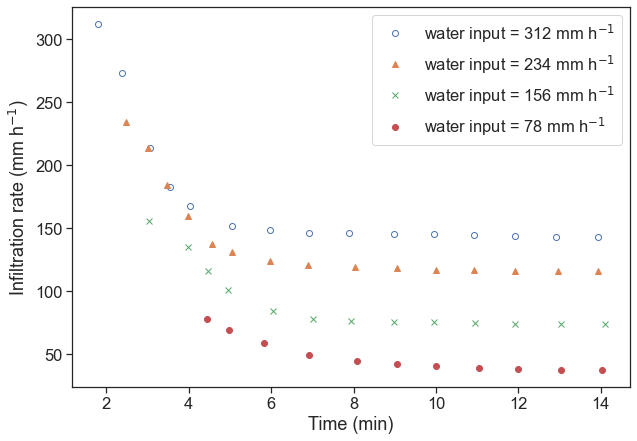

In [3]:
#collapse-hide

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(d4[:,0], d4[:,1], 'o', markerfacecolor="None", label=r"water input = 312 mm h$^{-1}$")
ax.plot(d3[:,0], d3[:,1], '^', label=r"water input = 234 mm h$^{-1}$")
ax.plot(d2[:,0], d2[:,1], 'x', label=r"water input = 156 mm h$^{-1}$")
ax.plot(d1[:,0], d1[:,1], 'o', label=r"water input = 78 mm h$^{-1}$")
ax.set(xlabel="Time (min)",
       ylabel=r"Infiltration rate (mm h$^{-1}$)")
ax.legend(loc="upper right");

## Horton's equation

$$
f = f_c+(f_0-f_c)e^{-\beta t}
$$

* $f$: infiltration rate
* $f_c$: infiltration capacity at large $t$
* $f_0$: initial infiltration capacity
* $\beta$: best fit empirical parameter

Write a function called `horton`, that receives time `t` and the three parameters, and returns the right-hand side of the equation above. Plot one of the data sets, together with a guess of the parameters that should **roughly** fit the data.

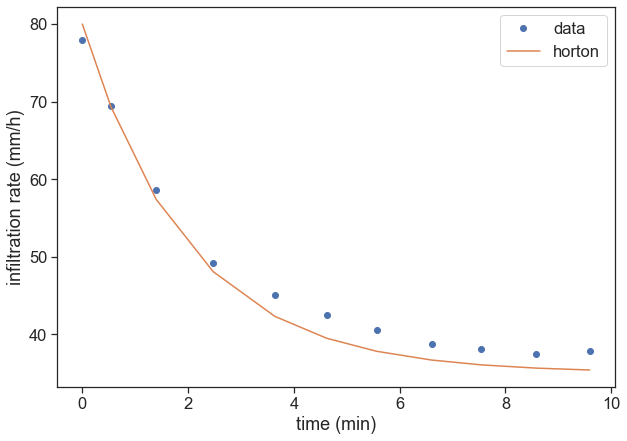

In [4]:
#collapse-hide

def horton(t, fc, f0, beta):
    return fc + (f0 - fc)*np.exp(-beta*t)

fig, ax = plt.subplots(figsize=(10,7))
t = d1[:,0]
t = t - t[0]
f = d1[:,1]
ax.plot(t, f, 'o', label="data")
ax.plot(t, horton(t, 35, 80, 0.5), '-', label="horton")
ax.set(xlabel="time (min)",
       ylabel="infiltration rate (mm/h)")
ax.legend(loc="upper right");

Find the best fit for the parameters $f_c, f_0, \beta$. Calculate the $R^2$ for each data set.

For the best fit, use scipy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). Write a function to compute the R-squared of your fit.

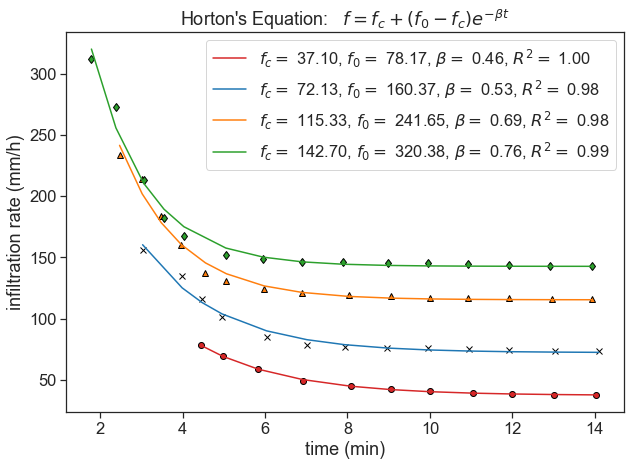

In [13]:
#collapse-hide

def horton(t, fc, f0, beta):
    return fc + (f0 - fc)*np.exp(-beta*t)

def best_fit(data):
    t = data[:,0]
    t0 = t[0]
    t = t - t0
    f = data[:,1]
    # best fit
    popt, pcov = curve_fit(f=horton,             # model function
                           xdata=t,              # x data
                           ydata=f,              # y data
                           p0=(130, 800, 0.5),   # initial guess of the parameters
                          )
    return [popt, pcov]

def calculate_r_squared(data, popt):
    t = data[:,0]
    t = t - t[0]
    f = data[:,1]
    # Calculate residuals
    residuals = f - horton(t, *popt)
    # You can get the residual sum of squares (ss_res) with
    ss_res = np.sum(residuals**2)
    # You can get the total sum of squares (ss_tot) with
    ss_tot = np.sum((f - np.mean(f))**2)
    # And finally, the r_squared-value with,
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def plot_best_fit(data, axis, marker, markercolor):
    # calculate best fit parameters
    popt, pcov = best_fit(data)
    t = data[:,0]
    f = data[:,1]
    # plot data points
    ax.plot(t, f, marker, markerfacecolor=markercolor, markeredgecolor="black")
    # plot best fit line
    r_squared = calculate_r_squared(data, popt)
    labeltext = r"$f_c=$ {:.2f}, $f_0=$ {:.2f}, $\beta=$ {:.2f}, $R^2=$ {:.2f}".format(popt[0],popt[1],popt[2], r_squared)
    ax.plot(t, horton(t-t[0], *popt), color=markercolor, label=labeltext)    

fig, ax = plt.subplots(figsize=(10,7))
plot_best_fit(d1, ax, 'o', "tab:red")
plot_best_fit(d2, ax, 'x', "tab:blue")
plot_best_fit(d3, ax, '^', "tab:orange")
plot_best_fit(d4, ax, 'd', "tab:green")
ax.set(xlabel="time (min)",
       ylabel="infiltration rate (mm/h)",
       title=r"Horton's Equation:   $f = f_c+(f_0-f_c)e^{-\beta t}$")
ax.legend();
# fig.savefig("horton-fit.png", dpi=500)

Make a graph of the infiltration rate and of the runoff, as a function of time. Use any of the four data sets you have.

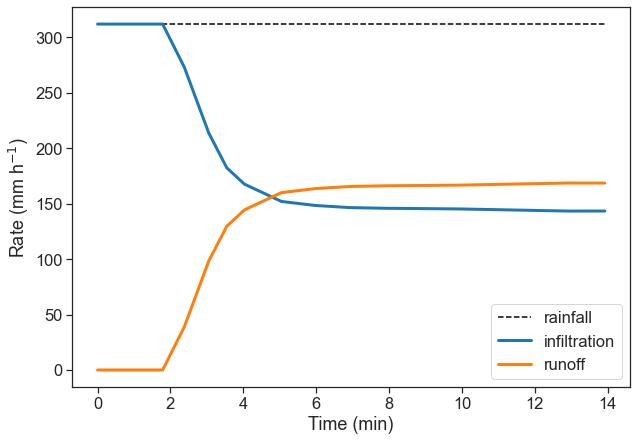

In [22]:
#collapse-hide

fig, ax = plt.subplots(figsize=(10,7))
data = d4
t = data[:, 0]
f = data[:, 1]
t = np.concatenate([ [0], t])
f = np.concatenate([ [f[0]], f])
runoff = f[0] - f
ax.plot(t, f*0 + f[0], ls="--", color="black", label="rainfall")
ax.plot(t, f, color="tab:blue", lw=3, label=r"infiltration")
ax.plot(t, runoff, color="tab:orange", lw=3, label=r"runoff")
ax.set(xlabel="Time (min)",
       ylabel=r"Rate (mm h$^{-1}$)")
ax.legend(loc="lower right");

## Green & Ampt

$$f = \frac{A}{F} + B$$

where
* $A = K_\text{sat}\cdot|\psi_f|\cdot \left( \phi - \theta_0 \right)$
* $B= K_\text{sat}$

Write a function that calculates the cumulative of the infiltration rate.

$$
F(t) = \int_0^t f(t) \text{ d}t
$$

Use numpy's `trapz` function, that implements the "trapezoidal rule"

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Composite_trapezoidal_rule_illustration.png/640px-Composite_trapezoidal_rule_illustration.png)

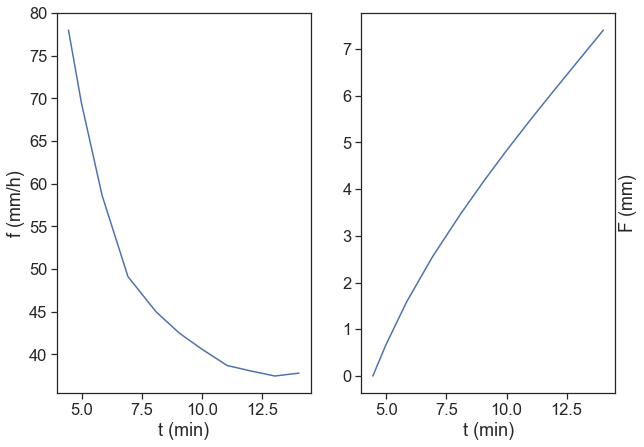

In [23]:
#collapse-hide

def cumulative_F(t, f):
    F = np.array([0])
    t = t/60 # convert minute to hour
    for i in np.arange(2,len(t)+1):
        area = np.trapz(f[:i], t[:i])
        F = np.concatenate([F, [area]])
    return F

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
t, f = d1[:,0], d1[:,1]
F = cumulative_F(t, f)
ax1.plot(t, f, label="f, rate")
ax2.plot(t, F, label="F, cumulative")
ax1.set(xlabel="t (min)",
        ylabel="f (mm/h)")
ax2.set(xlabel="t (min)",
        ylabel="F (mm)")
ax2.yaxis.set_label_position("right")

Plot $f$ as a function of $F$. Try to guess $A$ and $B$ that give reasonable results.

/Users/yairmau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


[Text(0.5, 0, 'F'), Text(0, 0.5, 'f')]

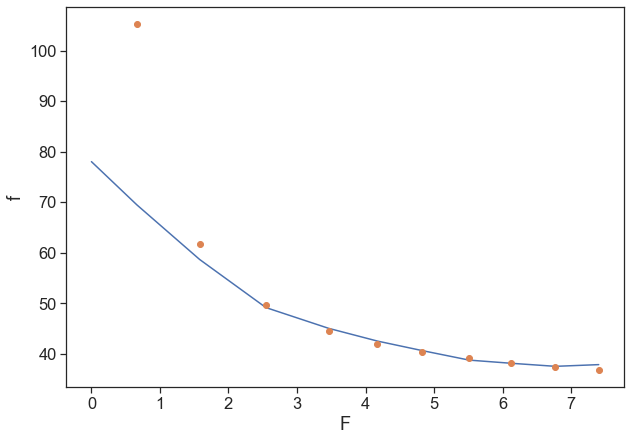

In [26]:
#collapse-hide

fig, ax = plt.subplots(figsize=(10,7))
t, f = d1[:,0], d1[:,1]
F = cumulative_F(t, f)
ax.plot(F, f)
A=50; B=30;
ax.plot(F, A/F + B, 'o')
ax.set(xlabel="F",
       ylabel="f")

Use the `curve_fit` to find the optimal values for $A$ and $B$.

[24.12368526 36.34242813]


[Text(0.5, 0, 'F'), Text(0, 0.5, 'f')]

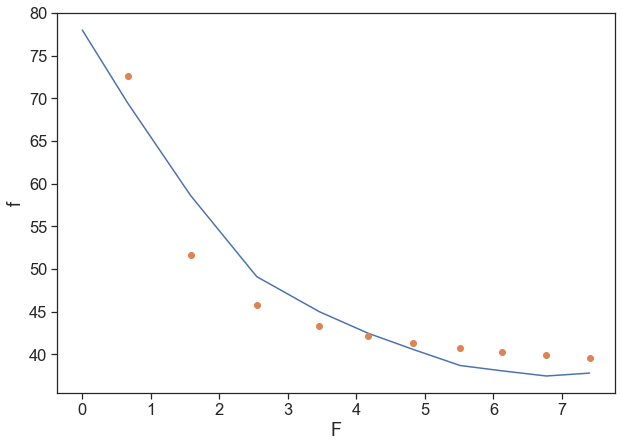

In [27]:
#collapse-hide

def G_and_A(F, A, B):
    return A/F + B

popt, pcov = curve_fit(f=G_and_A,     # model function
                       xdata=F[1:],       # x data
                       ydata=f[1:],       # y data
                       p0=(50, 30),   # initial guess of the parameters
                      )

# popt, pcov = curve_fit(G_and_A, F[1:], f[1:], p0=(50, 30))  # p0 = initial guess
print(popt)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(F, f)
ax.plot(F[1:], popt[0]/F[1:] + popt[1], 'o')
ax.set(xlabel="F",
       ylabel="f")

## Homework

Go to [Soil Texture Calculator](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_054167), estimate the texture of "standard soil" in Nassif & Wilson, 1975.